In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [13]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set

temp = calc_temps('2017-08-01', '2017-08-07')

temp_df = pd.DataFrame(temp, columns = ['tmin', 'tavg', 'tmax'])

temp_df

,tmin,tavg,tmax
0,72.0,79.25,83.0


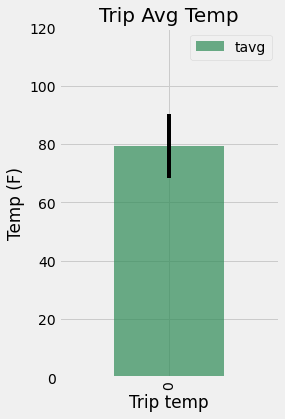

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yvalue = temp_df["tavg"]
yerr = temp_df["tmax"] - temp_df["tmin"]

temp_df.plot.bar(x = None, y = 'tavg', yerr= yerr, color = 'seagreen', figsize = (3.5,6), alpha = 0.7)

plt.title("Trip Avg Temp", fontsize = 20)
plt.ylabel("Temp (F)")
plt.xlabel("Trip temp")

plt.ylim(0,120)
plt.savefig("Images/temperature.png")
plt.show()

### Daily Rainfall Average

In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

select = [measurement.date, measurement.prcp, station.station, station.name, \
          station.latitude, station.longitude, station.elevation]

prcp = session.query(*select).filter(measurement.station == station.station).\
filter(measurement.date >= "2016-08-01").filter(measurement.date <= "2016-08-07").all()
# prcp

In [16]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_prcp_df = pd.DataFrame(prcp, columns = ["date", "precipitation", "station", "name", "latitude",\
                                             "longitude", "elevation"])
trip_prcp_df = trip_prcp_df.groupby(["station", "name", "latitude", "longitude", "elevation"], \
                                    as_index = False)['precipitation'].sum()

trip_prcp_df = trip_prcp_df.sort_values('precipitation', ascending = [False])

trip_prcp_df.head(20)


,station,name,latitude,longitude,elevation,precipitation
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18


### Daily Temperature Normals

In [17]:
from datetime import date, timedelta

In [18]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d",  measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = "2016-08-01"
trip_end = "2016-08-07"

# # Use the start and end date to create a range of dates
# delta = end_date-start_date       # as timedelta

# for d in range(delta.days + 1):
#     day = start_date + timedelta(days = d)
#     print(day)

trip_dates = pd.date_range(trip_start, trip_end, freq = 'D')
trip_dates


# Strip off the year and save a list of strings in the format %m-%d
trip_mm_dd = trip_dates.strftime('%m-%d')
trip_mm_dd

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals = []

for date in trip_mm_dd:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# create dict of dates and tobs for trip dates

# convert dict to dataframe
trip_date_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_date_df['date'] = trip_dates
trip_date_df.set_index(['date'],inplace=True)
trip_date_df.head()


,tmin,tavg,tmax
date,,,
2016-08-01,67.0,75.540000,83.0
2016-08-02,68.0,75.603774,84.0
2016-08-03,70.0,76.611111,85.0
2016-08-04,69.0,76.711538,84.0
2016-08-05,69.0,76.148148,82.0


Text(0, 0.5, 'Temperature')

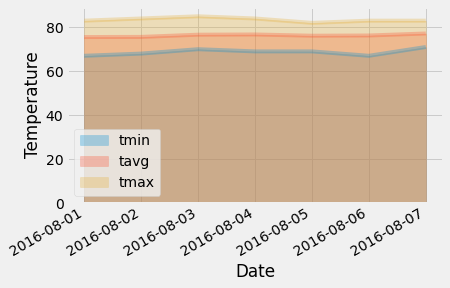

In [21]:
# Plot the daily normals as an area plot with `stacked=False`

trip_date_df.plot(kind='area', stacked=False, x_compat=True, alpha=.3, figsize=(6,4))
# plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")

## Close Session

In [22]:
session.close()